In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U numpy datasets --no-cache-dir


In [ ]:
#Librerias para procesamiento de datos
import pandas as pd
import numpy as np

#Librerias para limpieza de datos
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Librerias de evaluacion
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#librerias para convertir a formato de HuggingFace dataset
!pip install datasets
from datasets import Dataset

In [ ]:
#librerias para tokenizar datos de bert
!pip install transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
#Solo ejecutar esta celda en caso de que se tengan datos con formato HTML
!pip install beautifulsoup4
from bs4 import BeautifulSoup


In [ ]:
#Ruta del archivo del dataset
archivoCSV = '/content/drive/MyDrive/pishing/CEAS_08.csv'
dataFrame = pd.read_csv(archivoCSV)

#Comprobamos que se cargó correctamente
print("Dimenciones del dataset ", dataFrame.shape)
dataFrame.head()

Dimenciones del dataset  (39154, 7)


,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [ ]:
#Funcion para limpar el texto
def limpiarTextoBert(texto):
  if pd.isnull(texto):
    return ""

  texto = str(texto)                              #convertir la entrada a string
  texto = re.sub(r"http\S+|www.\S", "", texto)    #Eliminar los URLs
  texto = re.sub(r"\S+@\S","", texto)             #Eliminar las direcciones de email
  texto = re.sub(r"[^a-zA-Z]"," ", texto)         #Eliminar los numeros
  texto = texto.lower()                           #Normalizar texto a minusculas

  return texto


In [ ]:
#Aplicar limpieza de datos al dataFrame
dataFrame['text'] = dataFrame['body'].apply(limpiarTextoBert)
dataFrame = dataFrame[['text', 'label']]          #Nos quedamos solo con el texto y la etiqueta
dataFrame = dataFrame[dataFrame['text'].str.strip().astype(bool)] #Quitamos los espacios vacios

#Mostrar datos despues de limpiarlos
print("Dimenciones del dataset ", dataFrame.shape)
dataFrame.sample(5)

Dimenciones del dataset  (39152, 2)


,text,label
27443,sm wwt all pe yts ni xfo s si fjv ze is one of...,1
25500,three things of life that are most valuable ...,1
30220,on sat apr at am georg brandl ...,0
27333,on tue nov at am josh...,0
30238,find your next wife,1


In [ ]:
#Convertir el dataFrame a formato huggingFace
dataset = Dataset.from_pandas(dataFrame)
dataset = dataset.class_encode_column("label")

print(dataset)

Stringifying the column:   0%|          | 0/39152 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39152 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 39152
})


In [ ]:
#-------------TOKENIZACION---------------
#Cargar el tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Función para tokeniar el texto
def tokenizarLote(batch):
  return tokenizer(batch['text'],
                   padding="max_length",  #Rellenar hasta una longitud fija
                   truncation=True,       #Cortar si el texto supera la longitud
                   max_length=512         #Limite estandar de BERT
                   )

In [ ]:
#Aplicar la tokenizacion sobre los datos del batch
datasetTokenizado = dataset.map(tokenizarLote, batched=True)

Map:   0%|          | 0/39152 [00:00<?, ? examples/s]

In [ ]:
#Elimianr las columnas innesesarias
datasetTokenizado = datasetTokenizado.remove_columns(['text'])

datasetTokenizado = datasetTokenizado.rename_column("label", "labels")  #Renombrar la columnas por la esperada por el trainer

datasetTokenizado.set_format("torch")                                   #Establecer el formato de pytorch

In [ ]:
#Dividir el dataset -
datasetSplit = datasetTokenizado.train_test_split(test_size=0.2, seed=42)   #Separar el dataset formato 80-20

#Separar cada particion
datasetTrain = datasetSplit["train"]  #Parte de entrenamiento
datasetTest = datasetSplit["test"]    #Parte de prueba

print("Tamaño del entrenamiento: ", len(datasetTrain))
print("Tamaño de la prueba: ", len(datasetTest))

Tamaño del entrenamiento:  31321
Tamaño de la prueba:  7831


In [ ]:
#Definimos el modelo
modelo = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Definir los hyperparametros

argumentosEntrenamiento = TrainingArguments(
    output_dir = "/content/drive/MyDrive/pishing/resultados",              #Definir directorio de salida
    do_train = True,                          #Entrenar el modelo
    do_eval = True,                           #Evaluar el modelo
    eval_strategy = "epoch",                  #Evaluar el modelo cada epoca
    save_strategy = "epoch",                  #Guardar el modelo cada epoca
    logging_strategy = "epoch",               #Cargar el modelo cada epoca
    learning_rate = 2e-5,                     #Taza de ajuste de aprendizaje
    per_device_train_batch_size = 16,         #Batch de entrenamiento (tamaño)
    per_device_eval_batch_size = 16,          #Batch de evaluacion
    num_train_epochs = 3,                     #EPOCAS a entrenar
    weight_decay = 0.01,                      #Caida de los pesos
    load_best_model_at_end = True,            #Cargar el mejor modelo al terminar
    metric_for_best_model = "accuracy",       #metricas a usar
    report_to = "none",                        #Para no usar weights ni biases
    fp16=True                                 #Usar half precision
)

In [ ]:
#funcion para evalucar

def funcionMetricas(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=-1)
  return {
      "accuracy": accuracy_score(labels, preds),
      "precision": precision_score(labels, preds),
      "recall": recall_score(labels, preds),
      "f1": f1_score(labels, preds)
  }

In [ ]:
!pip install -U accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!accelerate config


In [ ]:
import torch
print("Dispositivo:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Dispositivo: cuda


In [ ]:
#Configurar trainer y entrenar

trainer = Trainer(
    model = modelo,                   #pasamos el modelo contruido
    args = argumentosEntrenamiento,   #pasamos los argumentos de entrenamiento
    train_dataset = datasetTrain,     #pasamos el dataset de pruebas
    eval_dataset = datasetTest,       #pasamos el dataset de prueba
    compute_metrics = funcionMetricas #aplicamos la funcion de metricas
)

trainer.train()           #Entrenar

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.042700,0.015593,0.995786,0.995715,0.996839,0.996277
2,0.007100,0.018179,0.996808,0.998416,0.995936,0.997174
3,0.001000,0.018036,0.996935,0.996842,0.997742,0.997292


TrainOutput(global_step=5874, training_loss=0.016948669956052712, metrics={'train_runtime': 2505.9343, 'train_samples_per_second': 37.496, 'train_steps_per_second': 2.344, 'total_flos': 2.472270409479168e+16, 'train_loss': 0.016948669956052712, 'epoch': 3.0})

In [ ]:
#Obtener predicciones
predicciones = trainer.predict(datasetTest)

#probabilidades
logits = predicciones.predictions
y_predict = np.argmax(logits, axis=-1)

#Etiquetas reales
y_real = predicciones.label_ids

In [ ]:
#Reporte de clasificacion
print(classification_report(y_real, y_predict, target_names=["Legitimo", "Pishing"]))

              precision    recall  f1-score   support

    Legitimo       1.00      1.00      1.00      3402
     Pishing       1.00      1.00      1.00      4429

    accuracy                           1.00      7831
   macro avg       1.00      1.00      1.00      7831
weighted avg       1.00      1.00      1.00      7831



<Figure size 600x400 with 0 Axes>

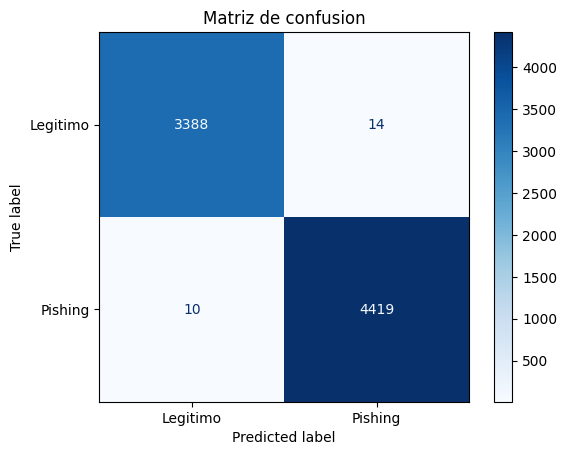

In [ ]:
#Generar matriz de confusion
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_real, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimo", "Pishing"])

plt.figure(figsize=(6,4))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusion")
plt.show()

In [ ]:
#--------APLICAR EL MODELO----------------------------
#Hacemos una prueba de inferencia sobre un nuevo correo

def PredecirCorreo(texto):
    # Limpieza ligera

    texto = re.sub(r"http\S+|www.\S+", "", texto)
    texto = re.sub(r"\S+@\S+", "", texto)
    texto = re.sub(r"\s+", " ", texto).strip()

    # Tokenizar
    inputs = tokenizer(
        texto,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )

    # Asegurar que esté en el mismo dispositivo que el modelo
    device = next(modelo.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Obtener predicción
    with torch.no_grad():
        salida = modelo(**inputs)
        logits = salida.logits
        pred = torch.argmax(logits, dim=1).item()

    return ["Legítimo", "Phishing"][pred]


In [ ]:
#Ejemplos de implementación
correo_1 = "Dear user, we detected unusual activity in your account. Please verify your login at our secure link."
correo_2 = "Hola equipo, les dejo el acta de la reunión pasada y el presupuesto. Saludos."

print("Correo 1:", PredecirCorreo(correo_1))
print("Correo 2:", PredecirCorreo(correo_2))

Correo 1: Legítimo
Correo 2: Phishing
